# Importing libraries

In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


# Scrapping data

This step is to collect 111500 links in an array by looping through 4460 pages with 25 car listings each.

In [15]:
links = []
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
for page_num in range(1, 4461):
    print(f'Page number: {page_num} / 4460')
    url = f'https://www.carlist.my/used-cars-for-sale/malaysia?page_number={page_num}&page_size=25'
    driver.get(url)
    WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.ID, 'classified-listings-result')))
    link_elem = driver.find_elements(By.XPATH, '//a[@class="ellipsize  js-ellipsize-text"]')
    for link in link_elem:
        href = link.get_attribute('href')
        if href:
            links.append(href)

driver.quit()

Page number: 1 / 4460
Page number: 2 / 4460
Page number: 3 / 4460
Page number: 4 / 4460
Page number: 5 / 4460
Page number: 6 / 4460
Page number: 7 / 4460
Page number: 8 / 4460
Page number: 9 / 4460
Page number: 10 / 4460
Page number: 11 / 4460
Page number: 12 / 4460
Page number: 13 / 4460
Page number: 14 / 4460
Page number: 15 / 4460
Page number: 16 / 4460
Page number: 17 / 4460
Page number: 18 / 4460
Page number: 19 / 4460
Page number: 20 / 4460
Page number: 21 / 4460
Page number: 22 / 4460
Page number: 23 / 4460
Page number: 24 / 4460
Page number: 25 / 4460
Page number: 26 / 4460
Page number: 27 / 4460
Page number: 28 / 4460
Page number: 29 / 4460
Page number: 30 / 4460
Page number: 31 / 4460
Page number: 32 / 4460
Page number: 33 / 4460
Page number: 34 / 4460
Page number: 35 / 4460
Page number: 36 / 4460
Page number: 37 / 4460
Page number: 38 / 4460
Page number: 39 / 4460
Page number: 40 / 4460
Page number: 41 / 4460
Page number: 42 / 4460
Page number: 43 / 4460
Page number: 44 / 44

In [16]:
len(links)

111500

Writing the links to a text file in case it's needed again.

In [22]:
with open("output.txt", "w") as file:
    for element in links:
        file.write(f"{element}\n")


In [2]:
with open("output.txt", "r") as file:
    all_links = [str(line.strip()) for line in file]


In [22]:
titles = []
years = []
years = []
manufacturers = []
mileages = []
colors = []
prices = []
transmissions = []
number_of_gears = []
doors = []
seat_capacities = []
assembled = []
engine_ccs = []
bores = []
strokes = []
compression_ratios = []
peak_powers = []
peak_torques = []
engine_types = []
direct_injections = []
aspirations = []
fuel_types = []
fuel_consumptions = []
top_speeds = []
steering_radii = []
steering_types = []
lengths = []
widths = []
heights = []
wheel_bases = []
kerb_weights = []
boot_spaces = []
fuel_tanks = []
front_brakes = []
rear_brakes = []
front_suspensions = []
rear_suspensions = []
front_tyres = []
rear_tyres = []
front_rims = []
rear_rims = []

This step loops through 15k links from the array of links to scrape 40 different features from each car listing.

In [23]:
options = webdriver.ChromeOptions()
options.add_experimental_option(
    "prefs", {
        "profile.managed_default_content_settings.images": 2,
    }
)

driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

all_links_15k = all_links[:15000]

for i, link in enumerate(all_links_15k):
    link_start_time = time.time()  
    driver.get(link)

    try:
        full_title = driver.find_element(By.XPATH, '//h1[@class="listing__title  u-color-dark  u-margin-bottom-xs  u-text-3  u-text-4@mobile  u-text-bold"]').text

        title = re.findall('\d{4} ([A-Z]\w+(?:-[A-Z]\w+)? .+?)(?= - Cars)', full_title)[0]
        
        year = re.findall('(\d{4})', full_title)[0]

        manufacturer = re.findall('\d{4} ([A-Z]\w+)', full_title)[0]
        
        card_carousel = driver.find_elements(By.XPATH, '//span[@class="u-text-bold  u-block"]')

        temp_mileage = card_carousel[2].text

        mileage = None

        match_mileage = re.search('(\d+(?:\s*-\s*\d+)?)\s*K?\s*KM', temp_mileage, re.IGNORECASE)

        if match_mileage:
            mileage = match_mileage.group(1)
            
            if ' - ' not in mileage:
                mileage = round(int(mileage) / 1000) * 1000
            
            else:
                lower_range = mileage.split('-')[0].strip()
                mileage = int(lower_range) * 1000

        color = card_carousel[3].text
        
        specifications_tab = driver.find_element(By.XPATH, '//a[contains(@class, "c-tab__item") and contains(@href, "#tab-specifications")]')
        driver.execute_script("arguments[0].click();", specifications_tab)

        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")    
 
        price = re.sub('RM\s*|,', '', driver.find_element(By.XPATH, '//div[@class="listing__price  u-text-4  u-text-bold"]').text)

        specs = driver.find_elements(By.XPATH, '//div[contains(@class, "u-border-bottom") and contains(@class, "u-flex")]')
        spec_dict = {}

        for spec in specs:
            try:
                key = re.sub(r"\s|\s*\([^)]*\)", "_", spec.find_elements(By.XPATH, './/span')[0].text.lower()).strip("_")
                val = spec.find_elements(By.XPATH, './/span')[1].text.lower()
                
                spec_dict[key] = val
            except:
                pass

        def append_value(key_name, target_list):
            value = spec_dict.get(key_name) 
            if value:
                target_list.append(value)  
            else:
                target_list.append(None)  

        titles.append(title)
        years.append(year)
        manufacturers.append(manufacturer)
        mileages.append(mileage)
        colors.append(color)
        prices.append(price)
        append_value('transmission', transmissions)
        append_value('number_of_gears', number_of_gears)
        append_value('doors', doors)
        append_value('seat_capacity', seat_capacities)
        append_value('assembled', assembled)
        append_value('engine_cc', engine_ccs)
        append_value('bore', bores)
        append_value('stroke', strokes)
        append_value('compression_ratio', compression_ratios)
        append_value('peak_power', peak_powers)
        append_value('peak_torque', peak_torques)
        append_value('engine_type', engine_types)
        append_value('direct_injection', direct_injections)
        append_value('aspiration', aspirations)
        append_value('fuel_type', fuel_types)
        append_value('fuel_consumption', fuel_consumptions)
        append_value('top_speed', top_speeds)
        append_value('steering_radius', steering_radii)
        append_value('steering_type', steering_types)
        append_value('length', lengths)
        append_value('width', widths)
        append_value('height', heights)
        append_value('wheel_base', wheel_bases)
        append_value('kerb_weight', kerb_weights)
        append_value('boot_space', boot_spaces)
        append_value('fuel_tank', fuel_tanks)
        append_value('front_brakes', front_brakes)
        append_value('rear_brakes', rear_brakes)
        append_value('front_suspension', front_suspensions)
        append_value('rear_suspension', rear_suspensions)
        append_value('front_tyre', front_tyres)
        append_value('rear_tyre', rear_tyres)
        append_value('front_rim', front_rims)
        append_value('rear_rim', rear_rims)

        link_elapsed_time = time.time() - link_start_time

        print(f"Got link {i+1} / {len(all_links_15k)} | Processing Time: {link_elapsed_time:.2f} seconds")

    except:
        print(f"Failed to get link {i+1} / {len(all_links_15k)} [{link}]")

driver.quit()


Got link 1 / 15000 | Processing Time: 8.13 seconds
Got link 2 / 15000 | Processing Time: 2.70 seconds
Failed to get link 3 / 15000 [https://www.carlist.my/used-cars/2023-bmw-i7-0-0-xdrive60-m-sport-sedan/15852355?bmw=true]
Got link 4 / 15000 | Processing Time: 2.44 seconds
Got link 5 / 15000 | Processing Time: 2.62 seconds
Got link 6 / 15000 | Processing Time: 2.53 seconds
Got link 7 / 15000 | Processing Time: 2.83 seconds
Got link 8 / 15000 | Processing Time: 2.37 seconds
Got link 9 / 15000 | Processing Time: 3.02 seconds
Got link 10 / 15000 | Processing Time: 3.08 seconds
Got link 11 / 15000 | Processing Time: 3.07 seconds
Got link 12 / 15000 | Processing Time: 2.67 seconds
Got link 13 / 15000 | Processing Time: 2.47 seconds
Got link 14 / 15000 | Processing Time: 2.72 seconds
Got link 15 / 15000 | Processing Time: 2.57 seconds
Got link 16 / 15000 | Processing Time: 1.03 seconds
Got link 17 / 15000 | Processing Time: 2.92 seconds
Got link 18 / 15000 | Processing Time: 2.97 seconds
Got

In [25]:
data = {
    "titles": titles,
    "years": years,
    "manufacturers": manufacturers,
    "mileages": mileages,
    "colors": colors,
    "prices": prices,
    "transmissions": transmissions,
    "number_of_gears": number_of_gears,
    "doors": doors,
    "seat_capacities": seat_capacities,
    "assembled": assembled,
    "engine_ccs": engine_ccs,
    "bores": bores,
    "strokes": strokes,
    "compression_ratios": compression_ratios,
    "peak_powers": peak_powers,
    "peak_torques": peak_torques,
    "engine_types": engine_types,
    "direct_injections": direct_injections,
    "aspirations": aspirations,
    "fuel_types": fuel_types,
    "fuel_consumptions": fuel_consumptions,
    "top_speeds": top_speeds,
    "steering_radii": steering_radii,
    "steering_types": steering_types,
    "lengths": lengths,
    "widths": widths,
    "heights": heights,
    "wheel_bases": wheel_bases,
    "kerb_weights": kerb_weights,
    "boot_spaces": boot_spaces,
    "fuel_tanks": fuel_tanks,
    "front_brakes": front_brakes,
    "rear_brakes": rear_brakes,
    "front_suspensions": front_suspensions,
    "rear_suspensions": rear_suspensions,
    "front_tyres": front_tyres,
    "rear_tyres": rear_tyres,
    "front_rims": front_rims,
    "rear_rims": rear_rims,
}

data_df = pd.DataFrame(data)



In [26]:
data_df.to_csv('carlist.csv', index=False)

# Data Preprocessing

In [5]:
df = pd.read_csv('carlist.csv')

In [6]:
df.shape

(13670, 40)

In [7]:
df.isna().sum()

titles                   0
years                    0
manufacturers            0
mileages                 0
colors                   0
prices                   0
transmissions            0
number_of_gears       2781
doors                    3
seat_capacities          3
assembled              324
engine_ccs             172
bores                 4882
strokes               4880
compression_ratios    4998
peak_powers            329
peak_torques           339
engine_types           324
direct_injections      500
aspirations            496
fuel_types               3
fuel_consumptions     5937
top_speeds            7137
steering_radii        4830
steering_types         324
lengths                333
widths                 333
heights                335
wheel_bases            328
kerb_weights          1695
boot_spaces           8773
fuel_tanks            1691
front_brakes          1258
rear_brakes           1526
front_suspensions     2220
rear_suspensions      2269
front_tyres           1945
r

Decision to drop certain columns is made due to some irrelevant columns and also to avoid bias in the dataset because some columns have too many null values. Drop NA afterwards to get rid of any remaining null values, leaving us with a little more than 10k data.

In [8]:
df = df.drop(columns=['titles', 'number_of_gears', 'bores', 'strokes', 'compression_ratios', 'fuel_consumptions', 'top_speeds', 'steering_radii', 'boot_spaces', 'front_brakes', 'rear_brakes','front_suspensions', 'rear_suspensions', 'front_tyres','rear_tyres']) 

In [9]:
df = df.dropna()
df.shape

(10627, 25)

In [10]:
df.columns

Index(['years', 'manufacturers', 'mileages', 'colors', 'prices',
       'transmissions', 'doors', 'seat_capacities', 'assembled', 'engine_ccs',
       'peak_powers', 'peak_torques', 'engine_types', 'direct_injections',
       'aspirations', 'fuel_types', 'steering_types', 'lengths', 'widths',
       'heights', 'wheel_bases', 'kerb_weights', 'fuel_tanks', 'front_rims',
       'rear_rims'],
      dtype='object')

In [11]:
columns = [col for col in df.columns if col != 'prices'] 
columns.append('prices')  

df = df[columns]
df.columns

Index(['years', 'manufacturers', 'mileages', 'colors', 'transmissions',
       'doors', 'seat_capacities', 'assembled', 'engine_ccs', 'peak_powers',
       'peak_torques', 'engine_types', 'direct_injections', 'aspirations',
       'fuel_types', 'steering_types', 'lengths', 'widths', 'heights',
       'wheel_bases', 'kerb_weights', 'fuel_tanks', 'front_rims', 'rear_rims',
       'prices'],
      dtype='object')

In [12]:
df = df[df['years'] <= 2024]

In [13]:
df['manufacturers'] = df['manufacturers'].str.lower()

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
valid_manufacturers = [
    "honda", "bmw", "perodua", "toyota", "proton", "mercedes", "mazda",
    "nissan", "volkswagen", "ford", "mitsubishi", "mini", "porsche", "volvo",
    "lexus", "renault", "subaru", "land", "audi", "lamborghini", "suzuki",
    "kia", "peugeot", "hyundai", "isuzu", "daihatsu", "bentley", "ferrari",
    "maserati", "rolls", "jaguar", "citroen", "infiniti", "chevrolet", "jeep",
    "aston", "mclaren"
]

df = df[df['manufacturers'].isin(valid_manufacturers)]

In [16]:
df = df[df['colors'] != "-"]

In [17]:
df['rear_rims'] = df['rear_rims'].astype(str)
df['front_rims'] = df['front_rims'].astype(str)

df['rear_rims'] = df['rear_rims'].str.split('x').str[0]

df['front_rims'] = df['front_rims'].str.split('x').str[0]

df['rear_rims'] = pd.to_numeric(df['rear_rims'], errors='coerce')
df['front_rims'] = pd.to_numeric(df['front_rims'], errors='coerce')

In [18]:
df.to_csv('carlist_cleaned.csv', index=False)

# Exploratory Data Analysis (EDA)

In [19]:
df.describe()

,years,mileages,doors,seat_capacities,engine_ccs,peak_powers,peak_torques,lengths,widths,heights,wheel_bases,kerb_weights,fuel_tanks,front_rims,rear_rims,prices
count,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10292.000000,10271.000000,10271.000000,1.029200e+04
mean,2017.489021,74595.802565,4.441897,5.150797,1859.091139,166.644092,239.771084,4499.403517,1788.964050,1559.782161,2703.641080,1426.816071,54.015838,16.842566,16.846656,9.527218e+04
std,3.477453,38128.294466,0.656863,0.839690,601.111962,81.585436,118.360706,390.501484,141.309384,131.882641,182.573828,351.700195,13.990517,1.750516,1.758039,1.354306e+05
min,2000.000000,0.000000,2.000000,2.000000,847.000000,53.000000,76.000000,1665.000000,1475.000000,1136.000000,2250.000000,765.000000,33.000000,12.000000,12.000000,4.900000e+03
25%,2015.000000,50000.000000,4.000000,5.000000,1496.000000,109.000000,145.000000,4299.000000,1700.000000,1467.000000,2555.000000,1120.000000,42.000000,15.000000,15.000000,3.880000e+04
50%,2018.000000,75000.000000,5.000000,5.000000,1799.000000,150.000000,210.000000,4525.000000,1799.000000,1515.000000,2678.500000,1441.000000,51.000000,17.000000,17.000000,6.020000e+04
75%,2020.000000,95000.000000,5.000000,5.000000,1998.000000,185.000000,300.000000,4709.000000,1840.000000,1668.000000,2810.000000,1605.000000,65.000000,18.000000,18.000000,9.999900e+04
max,2024.000000,370000.000000,5.000000,12.000000,6592.000000,799.000000,900.000000,5569.000000,4855.000000,2520.000000,3465.000000,2780.000000,108.000000,23.000000,23.000000,2.800000e+06


In [20]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,years,mileages,doors,seat_capacities,engine_ccs,peak_powers,peak_torques,lengths,widths,heights,wheel_bases,kerb_weights,fuel_tanks,front_rims,rear_rims,prices
years,1.000000,-0.682431,0.099032,-0.065624,-0.108756,0.045294,0.103349,0.058955,0.074290,0.082160,0.068069,0.072388,-0.104008,0.245642,0.244534,0.216462
mileages,-0.682431,1.000000,0.038067,0.110009,-0.075832,-0.207706,-0.215458,-0.076929,-0.103470,0.008374,-0.089996,-0.124650,-0.013836,-0.274731,-0.276839,-0.335411
doors,0.099032,0.038067,1.000000,0.409290,-0.240538,-0.251970,-0.242937,-0.284924,-0.002152,0.474853,-0.135178,-0.027788,-0.171688,-0.028052,-0.036424,-0.278020
seat_capacities,-0.065624,0.110009,0.409290,1.000000,-0.088838,-0.215975,-0.159259,0.011744,0.001759,0.385527,0.127453,0.117705,0.003734,-0.085737,-0.091391,-0.257866
engine_ccs,-0.108756,-0.075832,-0.240538,-0.088838,1.000000,0.821968,0.781509,0.555031,0.449257,0.149186,0.552264,0.691873,0.745325,0.589859,0.596985,0.640891
peak_powers,0.045294,-0.207706,-0.251970,-0.215975,0.821968,1.000000,0.895935,0.502337,0.462093,-0.034769,0.503758,0.661676,0.671468,0.752582,0.760870,0.791210
peak_torques,0.103349,-0.215458,-0.242937,-0.159259,0.781509,0.895935,1.000000,0.653320,0.499064,0.148829,0.709572,0.817377,0.795350,0.776344,0.780444,0.654722
lengths,0.058955,-0.076929,-0.284924,0.011744,0.555031,0.502337,0.653320,1.000000,0.491494,0.261905,0.881088,0.793345,0.782488,0.613361,0.611535,0.267732
widths,0.074290,-0.103470,-0.002152,0.001759,0.449257,0.462093,0.499064,0.491494,1.000000,0.199473,0.477620,0.584741,0.558284,0.543636,0.543704,0.296697
heights,0.082160,0.008374,0.474853,0.385527,0.149186,-0.034769,0.148829,0.261905,0.199473,1.000000,0.337328,0.467750,0.342073,0.106208,0.100225,-0.133677


<Axes: >

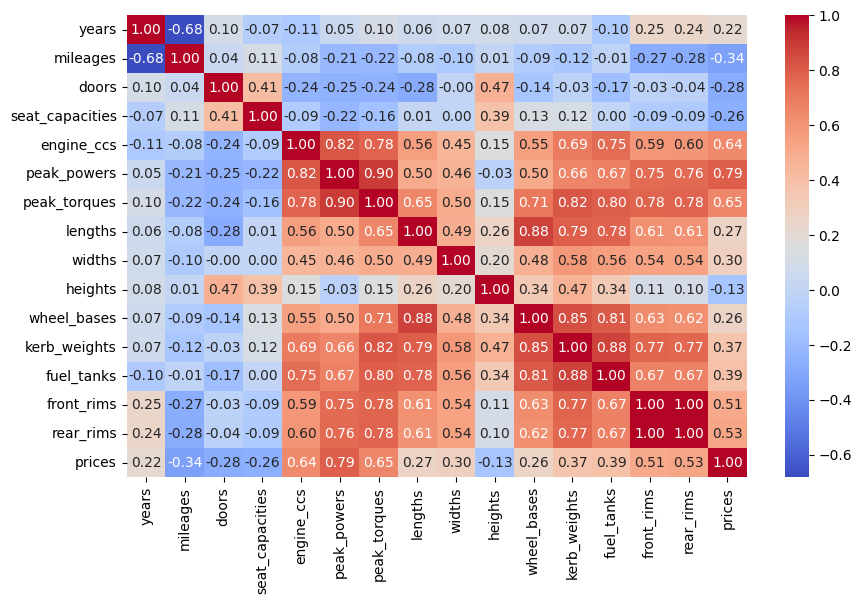

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

<Axes: xlabel='years', ylabel='prices'>

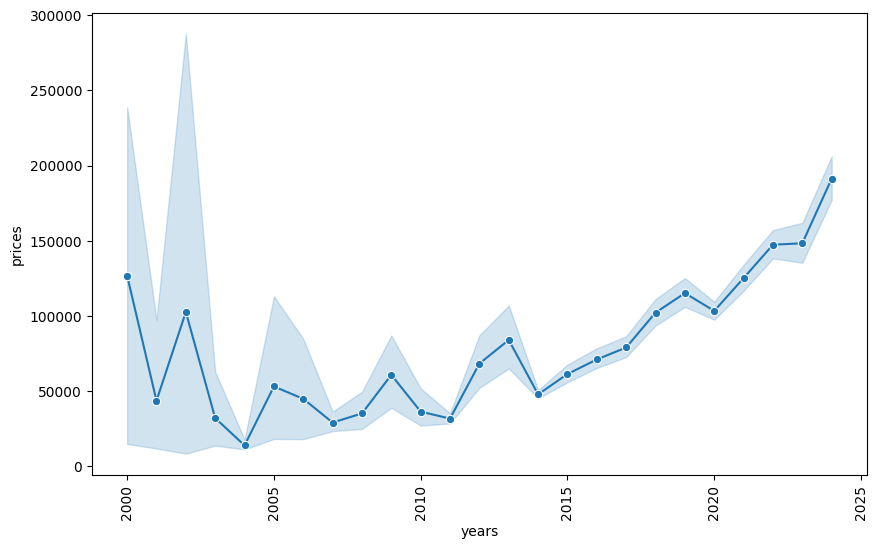

In [22]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
sns.lineplot(data=df, x='years', y='prices', marker='o')

It can be observed that generally the newer car the higher the price.

<Axes: xlabel='manufacturers', ylabel='Count'>

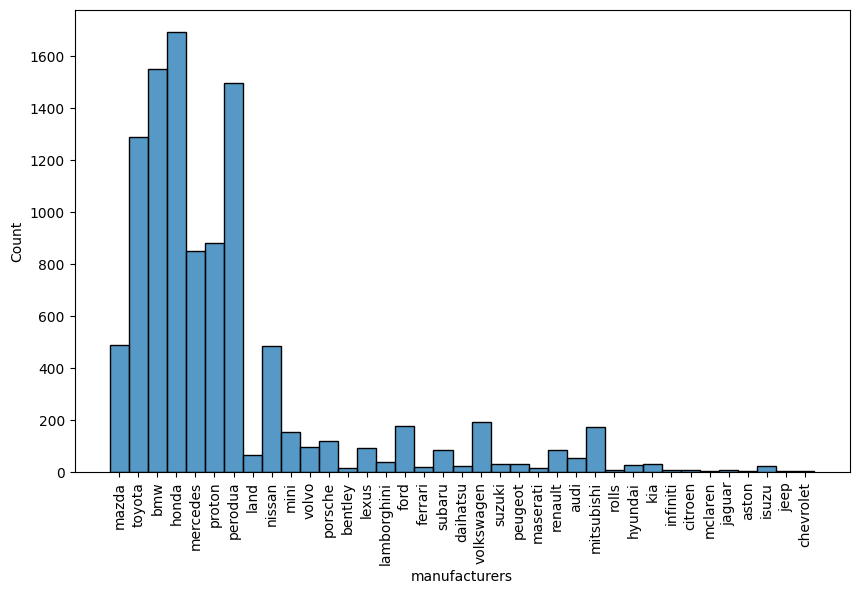

In [20]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
sns.histplot(data=df, x='manufacturers')

The top 3 most sold car brands in Malaysia are Honda, BMW and Perodua.

<Axes: xlabel='transmissions', ylabel='prices'>

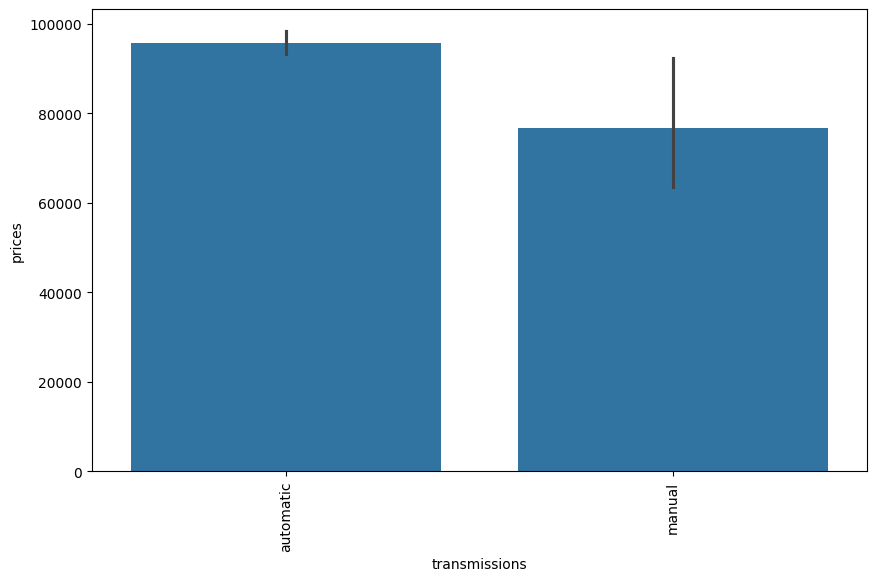

In [43]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
sns.barplot(data=df, x='transmissions', y='prices')

Automatics are generally more expensive than manuals (perhaps because of the age of the manual cars era)

<Axes: xlabel='colors', ylabel='prices'>

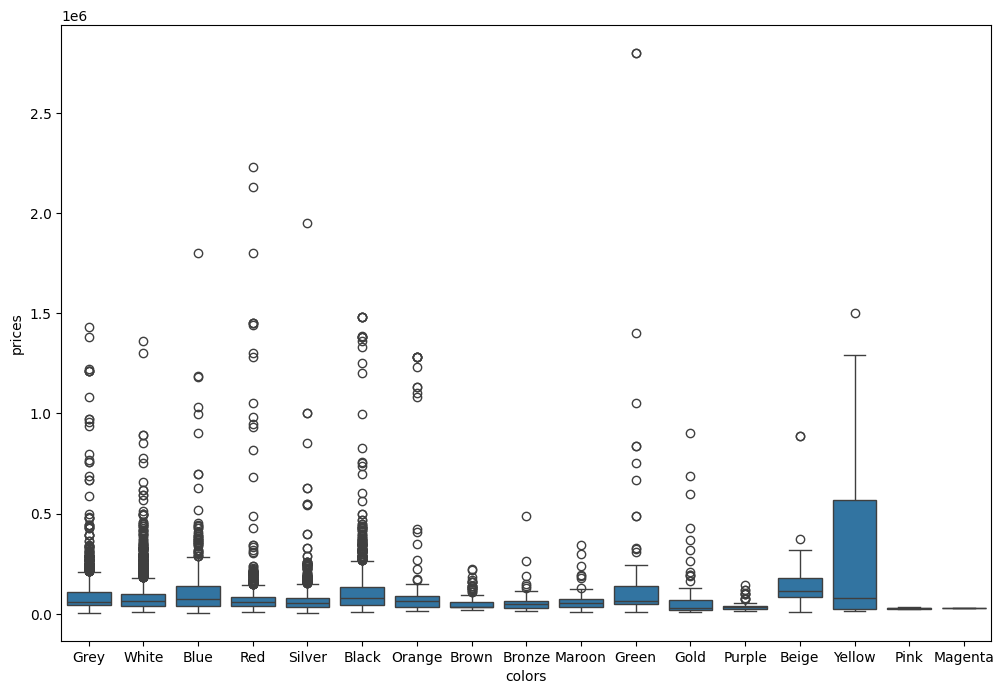

In [46]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='colors', y='prices')

Yellow cars are usually priced higher.

<Axes: xlabel='engine_ccs', ylabel='prices'>

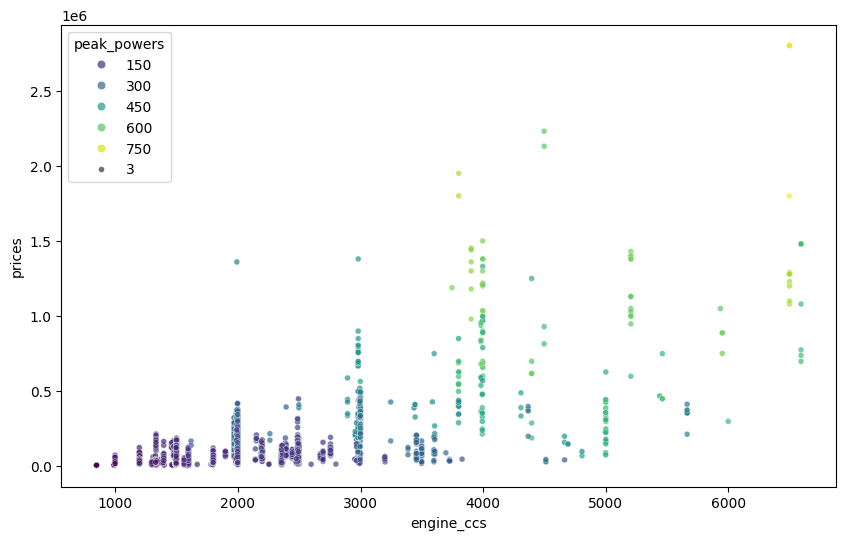

In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='engine_ccs', y='prices', hue='peak_powers', palette='viridis', size=3, alpha=0.7)

The higher the peak power (horsepower) the higher the price.

# Model development

In [78]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}  

for column in df.columns:
    if df[column].dtype == 'object':  
        label_encoder = LabelEncoder() 
        df[column] = label_encoder.fit_transform(df[column])  
        label_encoders[column] = label_encoder  

df.head()

,years,manufacturers,mileages,colors,transmissions,doors,seat_capacities,assembled,engine_ccs,peak_powers,...,steering_types,lengths,widths,heights,wheel_bases,kerb_weights,fuel_tanks,front_rims,rear_rims,prices
0,2019,20,65000,7,0,5.0,5.0,0,2488.0,194.0,...,2,4550.0,1840.0,1680.0,2700.0,1592.0,56.0,19.0,19.0,89800
1,2021,34,35000,15,0,5.0,5.0,0,1496.0,107.0,...,2,4140.0,1730.0,1475.0,2550.0,1140.0,42.0,16.0,16.0,66800
2,2021,3,30000,7,0,4.0,5.0,0,1998.0,184.0,...,2,4936.0,1868.0,1483.0,2975.0,1845.0,46.0,19.0,19.0,207000
3,2020,9,85000,15,0,5.0,5.0,0,1497.0,120.0,...,2,3989.0,1694.0,1668.0,2530.0,1099.0,40.0,16.0,16.0,65800
4,2019,22,80000,2,0,4.0,5.0,0,1497.0,184.0,...,2,4686.0,1810.0,1442.0,2840.0,1505.0,66.0,18.0,18.0,138888


In [79]:
for column, encoder in label_encoders.items():
    print(f"Column: {column}")
    print(f"Mapping: {dict(enumerate(encoder.classes_))}")


Column: manufacturers
Mapping: {0: 'aston', 1: 'audi', 2: 'bentley', 3: 'bmw', 4: 'chevrolet', 5: 'citroen', 6: 'daihatsu', 7: 'ferrari', 8: 'ford', 9: 'honda', 10: 'hyundai', 11: 'infiniti', 12: 'isuzu', 13: 'jaguar', 14: 'jeep', 15: 'kia', 16: 'lamborghini', 17: 'land', 18: 'lexus', 19: 'maserati', 20: 'mazda', 21: 'mclaren', 22: 'mercedes', 23: 'mini', 24: 'mitsubishi', 25: 'nissan', 26: 'perodua', 27: 'peugeot', 28: 'porsche', 29: 'proton', 30: 'renault', 31: 'rolls', 32: 'subaru', 33: 'suzuki', 34: 'toyota', 35: 'volkswagen', 36: 'volvo'}
Column: colors
Mapping: {0: 'Beige', 1: 'Black', 2: 'Blue', 3: 'Bronze', 4: 'Brown', 5: 'Gold', 6: 'Green', 7: 'Grey', 8: 'Magenta', 9: 'Maroon', 10: 'Orange', 11: 'Pink', 12: 'Purple', 13: 'Red', 14: 'Silver', 15: 'White', 16: 'Yellow'}
Column: transmissions
Mapping: {0: 'automatic', 1: 'manual'}
Column: assembled
Mapping: {0: 'locally built', 1: 'official import', 2: 'parallel import'}
Column: engine_types
Mapping: {0: 'piston', 1: 'rotary'}
Co

In [80]:
x = df.iloc[:, :-1]
y = df['prices']
len(x.columns)

24

In [81]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=12)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Random Forest Regression model is chosen because:
- Prices are influenced by complex, non-linear relationships

- It performs well even when the dataset has many features

- It's less sensitive to noisy data, which is common in datasets like these

In [82]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    error_score='raise'  
)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")



Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error: 619318449.8599417
R-squared Score: 0.963635531859626


Finding feature importance to identify how much impact each feature brings.

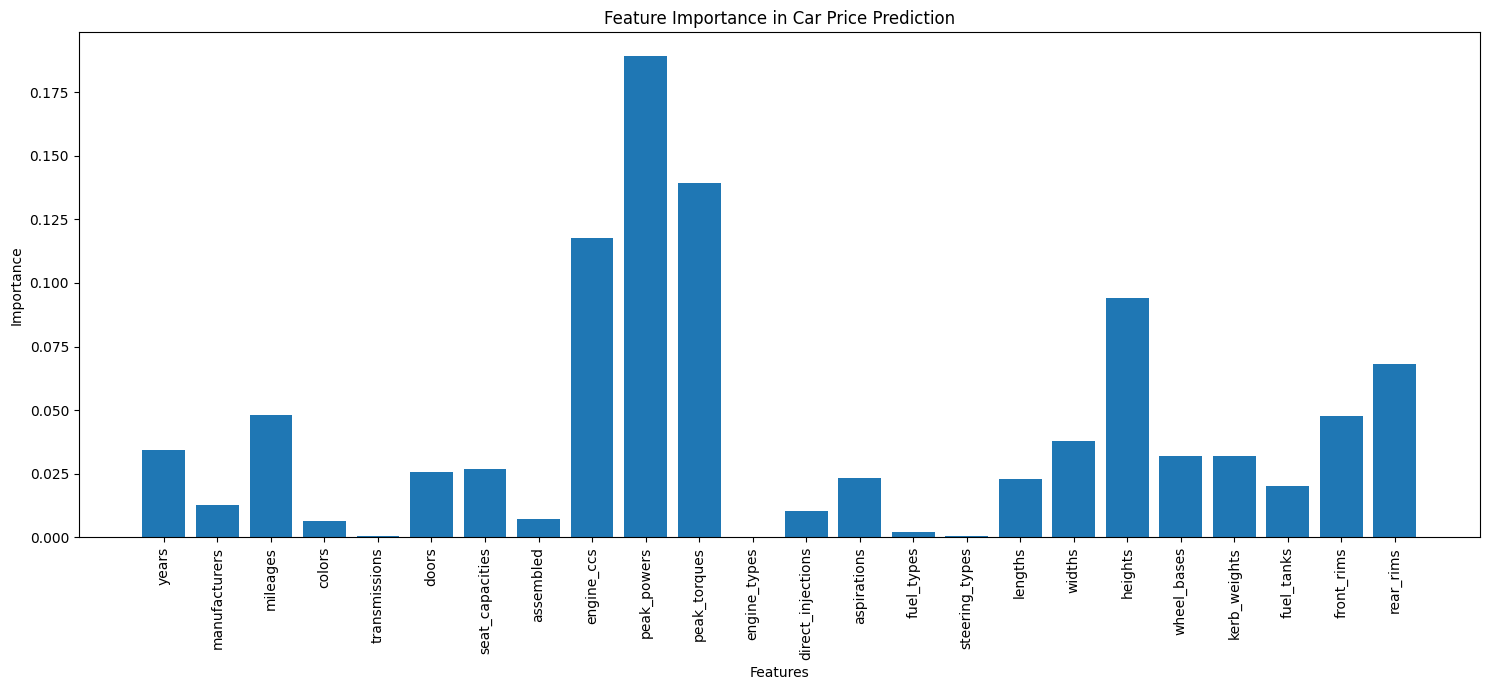

peak_powers: 18.91%
peak_torques: 13.93%
engine_ccs: 11.77%
heights: 9.42%
rear_rims: 6.81%


In [83]:
feature_importance = model.feature_importances_

plt.figure(figsize=(15, 7))
plt.bar(x.columns, feature_importance)
plt.title('Feature Importance in Car Price Prediction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

top_features = sorted(zip(x.columns, feature_importance), key=lambda x: x[1], reverse=True)[:5]
for feature, importance in top_features:
    print(f"{feature}: {importance * 100:.2f}%")


Model and scaler are saved using joblib.

In [84]:
joblib.dump(model, 'car_price_model.pkl')
joblib.dump(scaler, 'car_price_scaler.pkl')

['car_price_scaler.pkl']

The predicted price obtained from the model by inputing car features are similar to listed prices on other sites like mudah.my, with an error of less than RM 30K, which is in line with the Mean Squared Error.

Data Limitations:
- Lack of electric cars in dataset, leading to inaccurate predictions for electric vehicles
- Model names are not consistent, which limits further Exploratory Data Analysis